# DTSA-5509 Supervised Learning - Final Project
## An Supervised Machine Learning Analysis of NCAA Men's Basketball Regular Season and Subsequent Postseason Tournament Performance

### Project Topic
*Gives a clear explanation of what the project is about and clearly states both the type of learning/algorithms and type of task.*

For this final project I wanted to have some fun and at the same time put some machine learning skills I learned in this class to use. I found [a dataset on Kaggle](https://www.kaggle.com/competitions/march-machine-learning-mania-2023/data) that lists very detailed results of the NCAA men's basketball regular season and postseason games. To understand my project it might be necessary to have a basic understanding of how to the postseason tournament works. You can read about the tournament on [this Wikipedia page](https://en.wikipedia.org/wiki/2023_NCAA_Division_I_men%27s_basketball_tournament). The method of data collection is simply the records of each team over the regular season and NCAA tournament (if applicable.) I've played around with this dataset for other classes before but I am excited to use it for the first time on a supervised machine learning project.

*Clearly states the motivation or the goal for the project*

The goal of my final project will be to create supervised models with the purpose of predicting which teams will make the tournament itself - this is the **problem**. The type of learning will be a supervised approach and the type of tasks will be to use multiple linear regression, logistic regression and, to have fun and earn full points for the final, use a model that we have not learned in class which will be an unsupervised k-means clustering method.

My initial guess is that the results of this project will be just "OK". I say this because there is a good amound of randomness that takes place in the NCAA regular season and tournament, with "underdog" teams frequently defeating the expected winners. This is what makes the NCAA tournament fun and famously unpredictable. What is really cool, is that at that time of creating this project, the regular season has yet to be finished and tournament seeds decided, thus naturally creating my own test set for the model.

I want to clarify my actions here in this project in regards to the final project: While I am using data from a Kaggle competiton, the analysis will not be in relation to the goals of the competiton at all. I will **NOT** be replicating what is in the Kaggle kernel or other notebooks that can be found online. 

### Data

*Includes a brief explanation of where the data is from/how it was gathered and if the data is from a public source, cites the dataset using the format of a style manual like APA*

As I mentioned previously, this data is from a Kaggle project by the name of March Machine Learning Mania 2023. Jeff Sonas and Kenneth Massey assembled this dataset for the Kaggle competition, presuambly by mining publicly available statistics about NCAA Men's basketball, although I cannot confirm this. 

Here is the formal APA citation for Kaggle and for the Wikipedia general information (although this general informaiton was already known to me, the author of this project):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Jeff Sonas, Maggie, Will Cukierski, Kaggle Inc (2023). *March Machine Learning Mania 2023.* Kaggle. https://kaggle.com/competitions/march-machine-learning-mania-2023

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Wikipedia contributors. (2023). *2023 NCAA Division I men's basketball tournament.* Wikipedia, The Free Encyclopedia. https://en.wikipedia.org/w/index.php?title=2023_NCAA_Division_I_men%27s_basketball_tournament&oldid=1184173899

Lets start by looking at the data and describing the data's size.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm

# "gathering" the data:
fp = "C:/Users/bstrub/Documents/ml/DTSA5509finalproject/march-machine-learning-mania-2023/"
regseas = pd.read_csv(fp + "MRegularSeasonDetailedResults.csv") # import data from yearly regular seasons
tourney = pd.read_csv(fp + "MNCAATourneyCompactResults.csv") # import data from yearly tournaments
conf = pd.read_csv(fp + "MTeamConferences.csv") # import data about which team was in which conference by year
seeds = pd.read_csv(fp + "MNCAATourneySeeds.csv") # import data about which team was assigned to which seed
slots = pd.read_csv(fp + "MNCAATourneySlots.csv") # import data about which seed advanced to which round

print(regseas.head())
print(tourney.head())
print(conf.head())
print(seeds.head())

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

   ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0  ...     10    16    22   10   22     8   18     9     2   20  
1  ...     24     9    20   20   25     7   12     8     6   16  
2  ...     26    14    23   31   22     9   12     2     5   23  
3  ...     22     8    15   17   20     9   19     4     3   23  
4  ...     16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     123

*Describe the data including the data size appropriately for the type of data.*

Taking a look at the data as a whole, the initial size of this **multi-table form data** entire folder from Kaggle is 136 MB. To better strategize about my approach to modling this data, I want to understand the shape of some of the important features in the `regseas` table since this table contains all of the features that will be crucial in modeling the data. I would describe this data to be close to a relational type structure. 

In [4]:
# Metrics as a whole
metric_name = ["Number of unique seasons",
               "First season",
               "Most recent season",
               "Number of unique teams",
               "Number of unique games"]
metric_value = [len(pd.unique(regseas['Season'])),
                min(regseas['Season']),
                max(regseas['Season']),
                len(pd.unique(regseas['WTeamID'].tolist() + regseas['LTeamID'].tolist())),
                regseas.shape[0]]
total_metric_table = pd.DataFrame({'Metric Name':metric_name,'Metric Value':metric_value})
display(total_metric_table)

print(pd.unique(regseas['Season']))

,Metric Name,Metric Value
0,Number of unique seasons,21
1,First season,2003
2,Most recent season,2023
3,Number of unique teams,368
4,Number of unique games,106834


[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021 2022 2023]


In [5]:
print(regseas.describe())

              Season         DayNum        WTeamID         WScore  \
count  106834.000000  106834.000000  106834.000000  106834.000000   
mean     2013.105023      70.738304    1287.903720      75.591198   
std         5.920959      35.464312     105.084427      11.018139   
min      2003.000000       0.000000    1101.000000      34.000000   
25%      2008.000000      40.000000    1199.000000      68.000000   
50%      2013.000000      74.000000    1287.000000      75.000000   
75%      2018.000000     101.000000    1380.000000      83.000000   
max      2023.000000     132.000000    1477.000000     149.000000   

             LTeamID         LScore          NumOT           WFGM  \
count  106834.000000  106834.000000  106834.000000  106834.000000   
mean     1282.343262      63.618492       0.068574      26.276728   
std       104.336892      10.859575       0.305636       4.680234   
min      1101.000000      20.000000       0.000000      10.000000   
25%      1191.000000      56.0000

### Data Cleaning

The most important dataset out of the four that I loaded is the regular season (MRegularSeasonDetailedResults.csv) table. This is because my models will use the regualar season team performance to predict whether or not a given team will reach the NCAA tournament and out of the ones that do reach the tourney, how far they will go. Let's start by defining the features in this data:

- Season - Season by year (example: 2015 is the 2014-2015 season, since the NCAA basketball season spans between years)
- DayNum - indicator for the day in the season that the game was played
- WTeamID - Team ID (winning team)
- WScore - number of points scored (by the winng team)
- LTeamID - Team ID (losing team)
- LScore - number of points scored (by the losing team)
- NumOT - number of overtimes the game went to
- WLoc - location of the match in relation to the winning team (home, away, neutral) 
- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WTO - turnovers committed (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)
- LFGM - field goals made (by the losing team)
- LFGA - field goals attempted (by the losing team)
- LFGM3 - three pointers made (by the losing team)
- LFGA3 - three pointers attempted (by the losing team)
- LFTM - free throws made (by the losing team)
- LFTA - free throws attempted (by the losing team)
- LOR - offensive rebounds (pulled by the losing team)
- LDR - defensive rebounds (pulled by the losing team)
- LAst - assists (by the losing team)
- LTO - turnovers committed (by the losing team)
- LStl - steals (accomplished by the losing team)
- LBlk - blocks (accomplished by the losing team)
- LPF - personal fouls committed (by the losing team)

*Clear explanations of how and why cleaning steps were performed*

The first thing that you will likely notice about this dataset is that the grain is one row per game played. This will make it difficult to analyze by team performance, so I would like to reshape the data so that it is one row per game per team.

In [6]:
########################################
# DATA CLEANING: RESHAPING THE REGULAR SEASON DATAFRAME

# create an ID for the game
regseas['GameId'] = np.arange(len(regseas))

# create a variable for margin of victory (or loss)
regseas['WGameMargin'] = regseas['WScore'] - regseas['LScore']
regseas['LGameMargin'] = regseas['LScore'] - regseas['WScore']

# create winners dataset
wregseas = regseas.copy()
wregseas = wregseas[['Season','GameId','WTeamID','WScore','NumOT','WFGM','WFGA','WFGM3',
                   'WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF','WLoc',
                    'WGameMargin']] # select the columns that are 
                                    #relevant to the winners
wregseas['GameResult'] = 'win' # mark that the team won the game in question
wregseas = wregseas.rename(columns={'WTeamID':'TeamID','WScore':'PointsScored',
                                    'WFGM':'FGM','WFGA':'FGA','WFGM3':'FGM3','WFGA3':'FGA3','WFTM':'FTM',
                                    'WFTA':'FTA','WOR':'OFFR','WDR':'DEFR','WAst':'Ast','WTO':'TURNO',
                                    'WStl':'Stl','WBlk':'Blk','WPF':'PF', 'WLoc':'Loc',
                                    'WGameMargin':'GameMargin'}) # generalize column names


# create losers dataset
lregseas = regseas.copy()
lregseas = lregseas[['Season','GameId','LTeamID','LScore','WLoc','NumOT','LFGM','LFGA','LFGM3',
                   'LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF',
                    'LGameMargin']] # select the columns that are 
                                    #relevant to the losers
locrecode = {'H':'A','A':'H','N':'N'} # we need to recode the location for the game, because the location of the winner is
                                        # the opposite for the loser, except in the case where the game is being played in 
                                        # a neutral location
lregseas = lregseas.assign(Loc = lregseas.WLoc.map(locrecode)) # do the recoding
lregseas = lregseas.drop('WLoc',axis = 1)
lregseas['GameResult'] = 'loss' # mark that the team won the game in question
lregseas = lregseas.rename(columns={'LTeamID':'TeamID','LScore':'PointsScored', 
                                   'LFGM':'FGM','LFGA':'FGA','LFGM3':'FGM3','LFGA3':'FGA3',
                                   'LFTM':'FTM','LFTA':'FTA','LOR':'OFFR','LDR':'DEFR','LAst':'Ast',
                                   'LTO':'TURNO','LStl':'Stl','LBlk':'Blk','LPF':'PF',
                                    'LGameMargin':'GameMargin'}) # generalize column names


# combine datasets
allregseas = pd.concat([wregseas,lregseas])
allregseas.sort_values(by=['Season', 'GameId','GameResult'], inplace = True) # make dataset chronological
allregseas.reset_index(drop = True, inplace = True) # reset row index

# merge in the league in which the team played in that season
allregseas = pd.merge(allregseas,conf,how = "left",on = ['Season','TeamID'])

print(allregseas)

        Season  GameId  TeamID  PointsScored  NumOT  FGM  FGA  FGM3  FGA3  \
0         2003       0    1328            62      0   22   53     2    10   
1         2003       0    1104            68      0   27   58     3    14   
2         2003       1    1393            63      0   24   67     6    24   
3         2003       1    1272            70      0   26   62     8    20   
4         2003       2    1437            61      0   22   73     3    26   
...        ...     ...     ...           ...    ...  ...  ...   ...   ...   
213663    2023  106831    1429            65      0   21   51     7    27   
213664    2023  106832    1386            63      0   21   56     8    28   
213665    2023  106832    1433            88      0   31   59    11    19   
213666    2023  106833    1462            63      0   23   51     8    23   
213667    2023  106833    1437            64      0   25   56     6    19   

        FTM  ...  DEFR  Ast  TURNO  Stl  Blk  PF  Loc  GameMargin GameResul

*Utilize visualizations to look for any data-specific potential problems*

Now that our data is reshaped (the first step in cleaning data) let's examine some plots of the data:

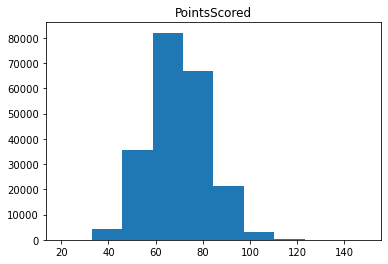

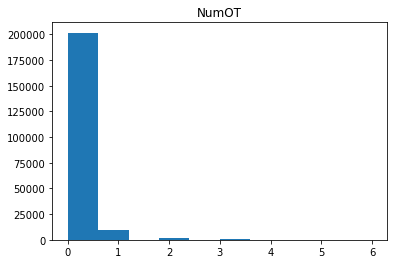

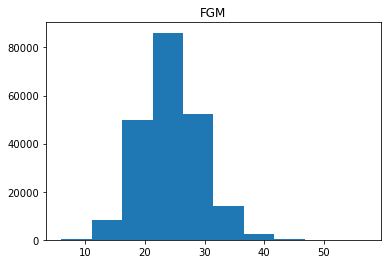

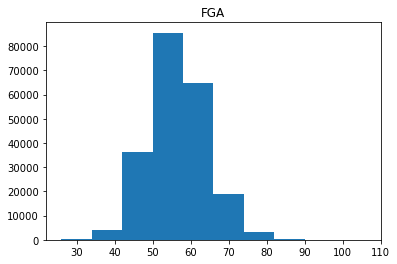

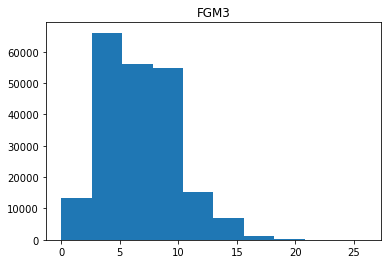

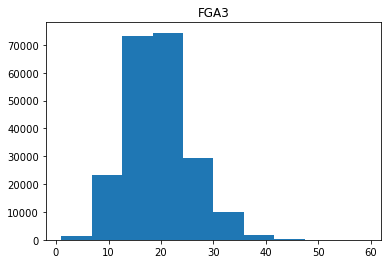

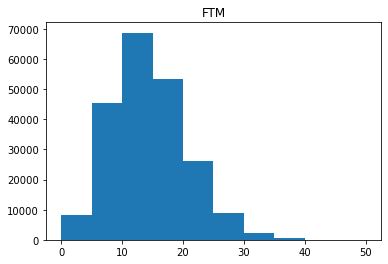

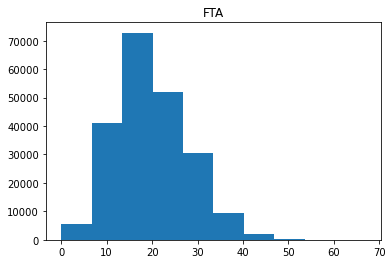

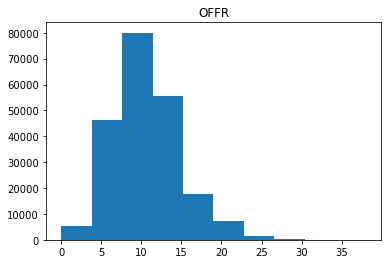

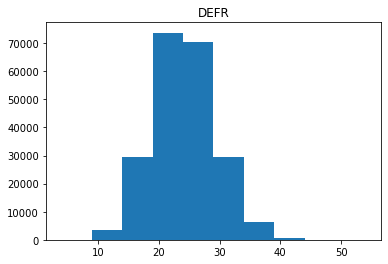

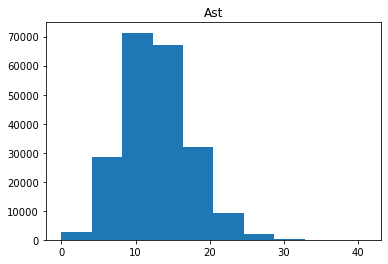

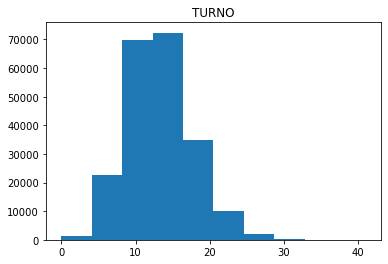

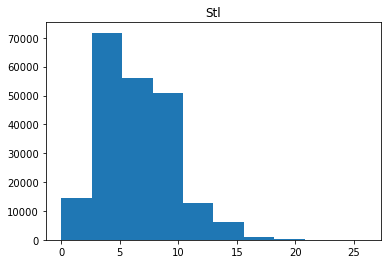

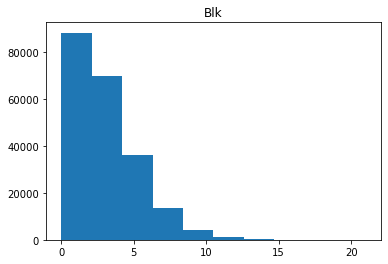

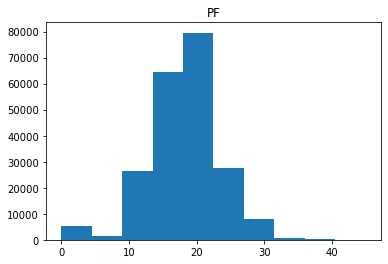

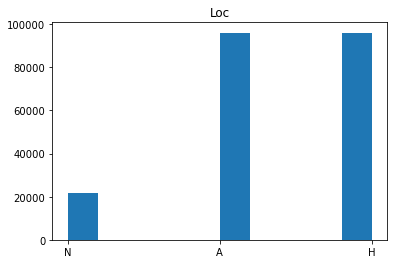

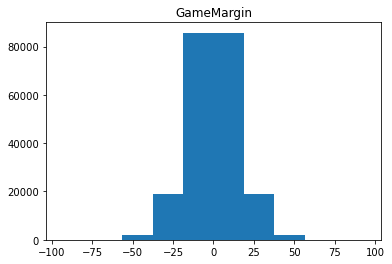

In [7]:
for c in ['PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OFFR', 'DEFR', 'Ast', 'TURNO', 
          'Stl', 'Blk', 'PF', 'Loc','GameMargin']:
    plt.hist(allregseas[c])
    plt.title(c)
    plt.show()

*Conclusions or discussions*

One of the things that I find intersting about these histograms is that they come in a lot of different shapes. Maybe I didn't think hard enough before I selected this data, but I assumed in my head that all of the basketball statistics would have more or less the same shape. It's really interesting to see some appear to be positivley skewed like the FTM feature (free-throws made), some appear slightly negatively skewed like the PF feature (personal fouls), and apparently normal, like the DEFR feature (defensive rebounds.)

From these plots, I don't see anything that jumps out at me as needing to be cleaned. 

**DATA CLEANING IS CONTINUED AFTER THE EDA STEP**

### Exploratory Data Analysis (EDA)

*EDA above and beyond expectations. E.g.in addition to simple plots, the author included at least two of the following (or similar):*

*correlation matrix with analysis*

In order to understand the corrleation in a dataset, one should take a look at the coorelation matrix. Let's do that here.

In [8]:
########################################
# DATA VISUALIZATION: PLOT CORRELATION
corrplot = allregseas.copy()
corrplot = corrplot[['PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OFFR', 
                     'DEFR', 'Ast', 'TURNO', 'Stl', 'Blk', 'PF', 'Loc', 'GameResult','GameMargin']] # delete columns that have 
                                                                                        # no value (the ID columns)
corr = corrplot.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision = 2)

,PointsScored,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OFFR,DEFR,Ast,TURNO,Stl,Blk,PF,GameMargin
PointsScored,1.00,0.18,0.86,0.39,0.48,0.19,0.44,0.39,0.09,0.29,0.61,-0.13,0.16,0.14,0.08,0.61
NumOT,0.18,1.00,0.14,0.22,0.06,0.09,0.13,0.14,0.09,0.15,0.05,0.06,0.04,0.05,0.12,-0.00
FGM,0.86,0.14,1.00,0.54,0.38,0.14,-0.03,-0.04,0.09,0.24,0.64,-0.16,0.16,0.13,-0.00,0.53
FGA,0.39,0.22,0.54,1.00,0.19,0.41,-0.15,-0.14,0.54,0.16,0.24,-0.23,0.19,0.08,0.09,0.03
FGM3,0.48,0.06,0.38,0.19,1.00,0.70,-0.11,-0.14,-0.10,0.05,0.48,-0.11,-0.01,-0.01,-0.03,0.28
FGA3,0.19,0.09,0.14,0.41,0.70,1.00,-0.18,-0.20,0.08,0.02,0.24,-0.15,0.02,-0.04,-0.01,0.00
FTM,0.44,0.13,-0.03,-0.15,-0.11,-0.18,1.00,0.93,0.08,0.19,-0.01,0.04,0.08,0.09,0.19,0.26
FTA,0.39,0.14,-0.04,-0.14,-0.14,-0.20,0.93,1.00,0.15,0.21,-0.02,0.06,0.11,0.10,0.22,0.22
OFFR,0.09,0.09,0.09,0.54,-0.10,0.08,0.08,0.15,1.00,0.04,-0.01,0.09,0.11,0.09,0.13,0.03
DEFR,0.29,0.15,0.24,0.16,0.05,0.02,0.19,0.21,0.04,1.00,0.20,0.12,-0.12,0.27,-0.02,0.46


*good analysis and conclusions/discussions*


Like the histograms from the previous EDA step, I find this plot to really interesting as well. Again, anyone who knows anything about basketball will tell you without looking at any correlation plots that field goals made (`FGM`) and the number of points a team scores (`PointsScored`) are going to be correlated. Having said that, it is enlightening to see this in statistical form. Looking at field goals attempted (`FGA`) and offensive rebounds (`OFFR`), something that is isn't necessarily intuitive is that field goals attempted is slightly correlated with the number of offensive rebounds a team gets. On the flip side, something that I personally think **would** be correlated is offensive rebounds (`OFFR`) and defensive rebounds (`DFFR`), that is to say, if a team is good at deffensive rebounds they would also be good offensive rebounds. However, this chart shows with a correlation value of .04, that this is not the case.

### Data Cleaning (CONTINUED) 

*impute missing values*

In order to model the results by season, we need to summarize the performace of each of the each team over the season in question. In order to do this, however, lets make sure each team in each league/season played the same amount of games:

In [9]:
testnumgames = allregseas[['Season','TeamID','ConfAbbrev','GameId']].groupby(['Season','ConfAbbrev','TeamID']).count()
testnumgames.columns = ['ngames']
testnumgames.reset_index(inplace = True)
print(testnumgames)
print(testnumgames[(testnumgames['Season'] == 2003) & (testnumgames['ConfAbbrev'] == 'a_sun')])# change this to any conference/
                                                                                                # year

      Season ConfAbbrev  TeamID  ngames
0       2003      a_sun    1125      28
1       2003      a_sun    1144      26
2       2003      a_sun    1194      27
3       2003      a_sun    1205      28
4       2003      a_sun    1209      28
...      ...        ...     ...     ...
7250    2023        wcc    1339      27
7251    2023        wcc    1360      26
7252    2023        wcc    1362      28
7253    2023        wcc    1365      28
7254    2023        wcc    1388      28

[7255 rows x 4 columns]
    Season ConfAbbrev  TeamID  ngames
0     2003      a_sun    1125      28
1     2003      a_sun    1144      26
2     2003      a_sun    1194      27
3     2003      a_sun    1205      28
4     2003      a_sun    1209      28
5     2003      a_sun    1239      28
6     2003      a_sun    1240      29
7     2003      a_sun    1273      28
8     2003      a_sun    1359      27
9     2003      a_sun    1391      26
10    2003      a_sun    1407      30
11    2003      a_sun    1416      31


As we can see from the above result, some teams played different numbers of games than the others in their conferences, putting them at a statisical disadvantage. Thus I believe we should **interpolate** the games that they didn't play.

*Note: a college basketball fan would point out that the reason many of these teams played fewer season games is because they weren't good enough to progress in their conference tournament, in which case putting them at a statistical disadvantage because they played fewer games is a good thing. However, for the purposes of this final project and displaying the concept of interpolation, I'm going to continute down the interpolation path.*

**Forewarning: the interpolation code takes approximately 15 minutes to run**

In [10]:
########################################
# EDA AND DATA CLEANING: INTERPOLATING DATA
startTime = time.time()

def interp_season(s, c, t, g, tempdf):
    # input: the season, the conference, the team, and the number of additional games to interpolate for
    # return: a pandas dataframe where the number of rows reflects the number of games to interpolate for
    
    df = tempdf.copy()
    df = df[(df['Season'] == s) & (df['ConfAbbrev'] == c) & (df['TeamID'] == t)]

    # interpolate numerics
    aggnum = df[['PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OFFR', 'DEFR', 'Ast', 'TURNO', 'Stl', 
                 'Blk', 'PF', 'GameMargin']].agg(['mean'])
    aggnum = aggnum.reset_index(drop=True)
    if g > 1:
        temp = pd.DataFrame(aggnum.copy())
        for i in range(1,g):
            aggnum = pd.concat([temp,aggnum])
    aggnum = aggnum.reset_index(drop=True)

    # adhoc interpolate non-numerics
    aggstr = pd.DataFrame({"Season":[s],
            "GameId":[-1],
            "Loc":df['Loc'].mode().iloc[0],
            "GameResult":df['GameResult'].mode().iloc[0],
            "ConfAbbrev":[c]})
    if g > 1:
        temp = pd.DataFrame(aggstr.copy())
        for i in range(1,g):
            aggstr = pd.concat([temp,aggstr])
    aggstr = aggstr.reset_index(drop=True)

        
    # now create the data frame to be returned
    returnme = aggstr.join(aggnum)
    returnme['TeamID'] = t
    returnme = returnme[['Season', 'GameId', 'TeamID', 'PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 
                         'OFFR', 'DEFR', 'Ast', 'TURNO', 'Stl', 'Blk', 'PF', 'Loc', 'GameMargin', 'GameResult', 'ConfAbbrev']]

    return returnme
    
    

allregseasinterp = allregseas.copy()

# get the maximum number of games any team from a given conference/year played during the season
getnumgames = testnumgames.groupby(['Season','ConfAbbrev']).agg({'ngames':['max']})
getnumgames.columns = ['maxngames']
getnumgames = getnumgames.reset_index()

# loop through each season/conference/team and interpolate (if necessary)
for s in testnumgames['Season'].unique():
    for c in testnumgames[(testnumgames['Season'] == s)]['ConfAbbrev'].unique():
        l = getnumgames[(getnumgames['Season'] == s) & (getnumgames['ConfAbbrev'] == c)]['maxngames'].iloc[0] # maximum number 
                                                                                                        # of games any team from
                                                                                                        # the conference played
                                                                                                        # in a season
        for t in testnumgames[(testnumgames['Season'] == s) & (testnumgames['ConfAbbrev'] == c)]['TeamID']:
            r = testnumgames[(testnumgames['Season'] == s) & (testnumgames['ConfAbbrev'] == c) 
                             & (testnumgames['TeamID'] == t)]['ngames'].iloc[0] # get the number of games a team played in the 
                                                                                # season
            g = l - r # count how many games the team is missing
            if (g != 0): # if statement to root out teams that don't need interpolation
                bindme = interp_season(s, c, t, g, allregseasinterp) # call interpolation function
                allregseasinterp = pd.concat([allregseasinterp,bindme])
                
                
endTime = time.time()
print(endTime - startTime)
print(allregseasinterp)

956.8672311306
    Season  GameId  TeamID  PointsScored     NumOT        FGM        FGA  \
0     2003       0    1328     62.000000  0.000000  22.000000  53.000000   
1     2003       0    1104     68.000000  0.000000  27.000000  58.000000   
2     2003       1    1393     63.000000  0.000000  24.000000  67.000000   
3     2003       1    1272     70.000000  0.000000  26.000000  62.000000   
4     2003       2    1437     61.000000  0.000000  22.000000  73.000000   
..     ...     ...     ...           ...       ...        ...        ...   
0     2023      -1    1337     77.307692  0.153846  28.500000  62.769231   
1     2023      -1    1337     77.307692  0.153846  28.500000  62.769231   
0     2023      -1    1339     75.851852  0.074074  24.814815  54.851852   
0     2023      -1    1360     77.038462  0.076923  27.269231  60.538462   
1     2023      -1    1360     77.038462  0.076923  27.269231  60.538462   

        FGM3       FGA3        FTM  ...       DEFR        Ast      TURNO

Alright, that took a long time. Lets see if the interpolation function was successful at plugging the gaps in the data.

In [11]:
testnumgames = allregseasinterp[['Season','TeamID','ConfAbbrev','GameId']].groupby(['Season','ConfAbbrev','TeamID']).count()
testnumgames.columns = ['ngames']
testnumgames.reset_index(inplace = True)
print(testnumgames)
print(testnumgames[(testnumgames['Season'] == 2023) & (testnumgames['ConfAbbrev'] == 'wcc')]) # change this to any conference/
                                                                                                # year

      Season ConfAbbrev  TeamID  ngames
0       2003      a_sun    1125      31
1       2003      a_sun    1144      31
2       2003      a_sun    1194      31
3       2003      a_sun    1205      31
4       2003      a_sun    1209      31
...      ...        ...     ...     ...
7250    2023        wcc    1339      28
7251    2023        wcc    1360      28
7252    2023        wcc    1362      28
7253    2023        wcc    1365      28
7254    2023        wcc    1388      28

[7255 rows x 4 columns]
      Season ConfAbbrev  TeamID  ngames
7245    2023        wcc    1140      28
7246    2023        wcc    1211      28
7247    2023        wcc    1258      28
7248    2023        wcc    1334      28
7249    2023        wcc    1337      28
7250    2023        wcc    1339      28
7251    2023        wcc    1360      28
7252    2023        wcc    1362      28
7253    2023        wcc    1365      28
7254    2023        wcc    1388      28


*look for any data-specific potential problems, and address issues found*

Based on the number of features in the data, I want to run a Primary Component Analysis transformation. While this is out of the scope of this class, it will help us by demonstrating multiple models later in the report and earning full credit for the final.

Keeping in mind the results of the correlation matrix above, I have decided that for my project, I want to run models on four different datasets:

1. The interpolated data
2. The interpolated data with PCA transformation
3. The regular data with highly correlated columns removed
4. The regular data with highly correlated columns with PCA transformation

Why run just one data set when we have the programming power to programatically run multiple? We've already computed dataset #1: the interpolated data. All that remains is #3 (a trivial case of removing columns based on the correlation matrix), #2 and #4, the PCA datasets.

For #3 and #4, I will drop columns based on their correlation values and knowledge of the game of basketball. For example, a good free-throw shooting team will make around 90% of their free throws. Thus we should eliminate `FTA` in favor of `FTM` since because we know that they will be highly correlated.

I will also collapse the data using the mean of the column so that we have 1 line per season/team for modeling purposes.

In [12]:
# create reponse column
seeds['MadeTourney'] = 1
seedsmt = seeds[['Season','TeamID','MadeTourney']].drop_duplicates(keep='first')

## Create dataset 1
allregseasinterpf = allregseasinterp[allregseasinterp['Season'] != 2023] # 2023 season is not complete yet so drop these
allregseasinterpf = allregseasinterpf.drop(['GameId','Loc','GameResult','ConfAbbrev'],axis = 1) 
allregseasinterpf = allregseasinterpf.groupby(['Season','TeamID']).mean()
allregseasinterpf.reset_index(inplace = True)
allregseasinterpf = allregseasinterpf.drop_duplicates(keep='first')

## Create dataset 2
# run PCA
# remove cols unrelated to to PCA and future modeling
allregseasinterppcaf = allregseasinterpf.drop(['Season','TeamID'],axis = 1) 
min_var_explained = 0.98
pca = PCA(n_components = min_var_explained, svd_solver = "full")
allregseasinterppcaf = pca.fit_transform(allregseasinterppcaf)


## Create dataset 3
# remove features
allregseascorf = allregseas[allregseas['Season'] != 2023]
allregseascorf  = allregseascorf.drop(['GameId','Loc','GameResult','ConfAbbrev'],axis = 1) 
allregseascorf  = allregseascorf.groupby(['Season','TeamID']).mean()
allregseascorf.reset_index(inplace = True)
allregseascorf  = allregseascorf.drop_duplicates(keep='first')
allregseascorf = allregseascorf.drop(['PointsScored','GameMargin','FGA','FTA','FGA3'],axis = 1) # drop correlated values 


# Create dataset 4
# run PCA
# remove cols unrelated to to PCA and future modeling
allregseascorpcaf = allregseascorf.drop(['Season','TeamID'],axis = 1)
min_var_explained = 0.98
pca = PCA(n_components = min_var_explained, svd_solver = "full")
allregseascorpcaf = pca.fit_transform(allregseascorpcaf)



# Create labels for dataset 1 and 2
allregseasinterpf = pd.merge(allregseasinterpf,seedsmt, how = 'left', on = ['Season','TeamID'])
allregseasinterpf['MadeTourney'] = allregseasinterpf['MadeTourney'].fillna(0) # mark teams that did not make the tourney
allregseasinterpflabs = allregseasinterpf['MadeTourney'].tolist()
allregseasinterpf = allregseasinterpf.drop(['MadeTourney'],axis = 1)

# Create labels for dataset 3 and 4
allregseascorf = pd.merge(allregseascorf,seedsmt, how = 'left', on = ['Season','TeamID'])
allregseascorf['MadeTourney'] = allregseascorf['MadeTourney'].fillna(0) # mark teams that did not make the tourney
allregseascorflabs = allregseascorf['MadeTourney'].tolist()
allregseascorf = allregseascorf.drop(['MadeTourney'],axis = 1)


print(allregseasinterpf.shape)
print(allregseasinterppcaf.shape)
print(allregseascorf.shape)
print(allregseascorpcaf.shape)

(6892, 18)
(6892, 9)
(6892, 13)
(6892, 9)


*conclusions or discussions* 

At this point, we have already discarded, interpolated and substituted values based on their coorrelation to other features and based on our knowledge of the game of basketball. However, we do need to collapse the data so that we have 1 row per game for modelling purposes. 

I beleive that the `FGM` feature will play the largest role in the analysis. This is because field goals made is the primary method of point scoring in basketball and determining the outcome of the match. While here and there mediocre teams may make a lot of field goals, over the course of the season the power of the offense should regress to a mean with the best teams making the most field goals. In addition, I beleive defensive rebounds (`DEFR`) may also play a large role. This is because this is a metric of a teams ability to create possesion of a opponents missed shot. It is a indicator of defensive ability.

### Models

As a refresher, we want to predict which teams will reach the NCAA tournament based on their regular season results. We will *attempt* to accomplish this by performing multiple linear regression, logistic regression, and supervised k-means clustering. Let's start with the simplest case: multiple linear regression.

*multiple ML models* 

#### Multiple linear regression
A great place to start this analysis would be simple linear regression. To begin, and to get full points for this section, it makes senses to start by looking at some plots to see which variables may be relevant. For purposes of making this report concise, I am going to present a few relevant plots here instead of all of the permutations of variables as plots.

In [13]:
# run linear regression here
# [work to do here]
df = allregseasinterpf.copy()
df['PercFGM'] = df['FGM']/df['FGA']
df['PercFGM3'] = df['FGM3']/df['FGA3']
df['MadeTourney'] = np.array(allregseasinterpflabs, dtype=bool).tolist()
df.loc[df['MadeTourney'] == True, 'MadeTourneyBool'] = 1
df.loc[df['MadeTourney'] == False, 'MadeTourneyBool'] = 0
df_train = df[df['Season'] <= 2020]
df_test = df[df['Season'] == 2021]

print(df_train.head())
# clf = LinearRegression()
print(allregseasinterpf.columns)

   Season  TeamID  PointsScored     NumOT        FGM        FGA      FGM3  \
0    2003    1102     57.250000  0.000000  19.142857  39.785714  7.821429   
1    2003    1103     78.777778  0.296296  27.148148  55.851852  5.444444   
2    2003    1104     69.285714  0.035714  24.035714  57.178571  6.357143   
3    2003    1105     71.769231  0.153846  24.384615  61.615385  7.576923   
4    2003    1106     63.607143  0.035714  23.428571  55.285714  6.107143   

        FGA3        FTM        FTA  ...        Ast      TURNO       Stl  \
0  20.821429  11.142857  17.107143  ...  13.000000  11.428571  5.964286   
1  16.074074  19.037037  25.851852  ...  15.222222  12.629630  7.259259   
2  19.857143  14.857143  20.928571  ...  12.107143  13.285714  6.607143   
3  20.769231  15.423077  21.846154  ...  14.538462  18.653846  9.307692   
4  17.642857  10.642857  16.464286  ...  11.678571  17.035714  8.357143   

        Blk         PF  GameMargin   PercFGM  PercFGM3  MadeTourney  \
0  1.785714  18

*good amount of visualizations*

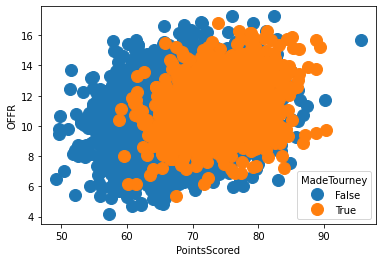

In [14]:
groups = df_train.groupby('MadeTourney')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.PointsScored, group.OFFR, marker='o', linestyle='', ms=12, label=name)
ax.legend(title='MadeTourney')
plt.xlabel("PointsScored")
plt.ylabel("OFFR")
plt.show()

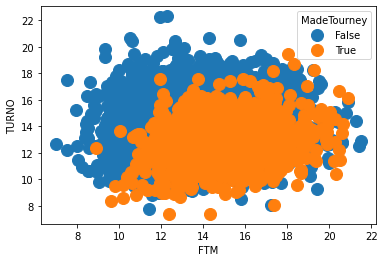

In [15]:
groups = df_train.groupby('MadeTourney')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.FTM, group.TURNO, marker='o', linestyle='', ms=12, label=name)
ax.legend(title='MadeTourney')
plt.xlabel("FTM")
plt.ylabel("TURNO")
plt.show()

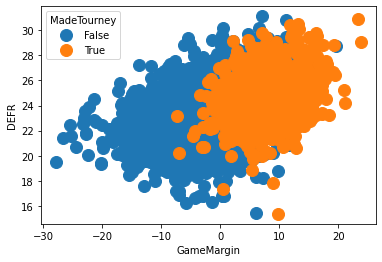

In [16]:
groups = df_train.groupby('MadeTourney')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.GameMargin, group.DEFR, marker='o', linestyle='', ms=12, label=name)
ax.legend(title='MadeTourney')
plt.xlabel("GameMargin")
plt.ylabel("DEFR")
plt.show()

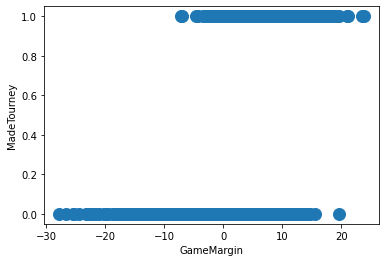

In [17]:
fig, ax = plt.subplots()
ax.plot(df_train.GameMargin, df_train.MadeTourney, marker='o', linestyle='', ms=12, label=name)
plt.xlabel("GameMargin")
plt.ylabel("MadeTourney")
plt.show()

In [44]:
model = smf.ols("MadeTourneyBool ~ GameMargin", data = df_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        MadeTourneyBool   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     3111.
Date:                Tue, 21 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:48:17   Log-Likelihood:                -1639.2
No. Observations:                6187   AIC:                             3282.
Df Residuals:                    6185   BIC:                             3296.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1900      0.004     47.350      0.0

Looking at the R-squared value, this isn't a bad first pass given a single variable for a complex problem such as this. Let's check and see how it does fitted to data:

In [45]:
df_test['fitted'] = model.predict(df_test)
final_df = df_test.sort_values('fitted',ascending=False)
final_df = final_df.head(64)
print(final_df.loc[final_df['MadeTourneyBool'] == 1].shape[0]/final_df.shape[0])

0.65625


C:\Users\bstrub\AppData\Local\Temp\ipykernel_12408\1875649002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['fitted'] = model.predict(df_test)


65% success isn't that bad, especially for a single feature on our first try. Let's expand the number of features and see if we can improve:

In [46]:
model = smf.ols("MadeTourneyBool ~ GameMargin + PercFGM + DEFR + TURNO + Stl + PercFGM3", data = df_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        MadeTourneyBool   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     520.2
Date:                Tue, 21 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:48:22   Log-Likelihood:                -1634.9
No. Observations:                6187   AIC:                             3284.
Df Residuals:                    6180   BIC:                             3331.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0786      0.125      0.630      0.5

In [49]:
df_test['fitted2'] = model.predict(df_test)
final_df = df_test.sort_values('fitted2',ascending=False)
final_df = final_df.head(64)
print(final_df.loc[final_df['MadeTourneyBool'] == 1].shape[0]/final_df.shape[0])

      Season  TeamID  PointsScored     NumOT        FGM        FGA       FGM3  \
6187    2021    1101     76.304348  0.000000  27.173913  59.043478   8.130435   
6188    2021    1102     58.720000  0.000000  20.880000  46.800000   6.960000   
6189    2021    1103     76.571429  0.095238  26.571429  60.714286   9.380952   
6190    2021    1104     79.566667  0.000000  27.800000  64.566667  10.666667   
6191    2021    1105     63.333333  0.133333  23.133333  57.866667   5.533333   
...      ...     ...           ...       ...        ...        ...        ...   
6529    2021    1467     66.277778  0.055556  24.111111  53.722222   7.000000   
6530    2021    1468     72.555556  0.000000  27.277778  54.500000   6.333333   
6531    2021    1469     67.631579  0.000000  23.368421  57.842105   5.842105   
6532    2021    1470     63.866667  0.000000  22.000000  50.866667   5.466667   
6533    2021    1471     68.642857  0.071429  25.714286  55.928571  10.142857   

           FGA3        FTM 

C:\Users\bstrub\AppData\Local\Temp\ipykernel_12408\3072580081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['fitted2'] = model.predict(df_test)


After this test, our accuracy actually went down this time. R-squared also went down, meaning that our data isn't explaining these results. This suggests to me that a linear model might not be the best solution to make accurate predicitons on this data. To accomplish this, let's try logistic regression and k-means clustering.

#### Logistic regression 

Now, I want to give supervised logistic regression a try. For the train/test split, we have 19 years of data, so in order to come as close to 80/20 as possible, I'll use 2022 and 2021 as the test seasons and the rest as the training seasons.

In [53]:
def label_compare_logistic(t,p):
    # input: a data frame with the original values and an array of predicted values
    # output: a printed statement of the accuracy
    test = pd.DataFrame({'t':t,'p':p})
    test['test'] = test['t'] == test['p']
    acc = len(test[test['test'] == True])/len(test)
    print(acc)

def run_poisson(df,l):
    # input: a data frame to regress on and the labels.
    # output: None.
    
    # split into train and test split
    df['MadeTourney'] = np.array(l, dtype=bool).tolist()
    df_train = df[df['Season'] <= 2020]
    df_test = df[df['Season'] >= 2021]
    if 'PointsScored' in df.columns:
            df_X_train = df_train[['PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3','FGA3', 'FTM', 'FTA', 'OFFR', 'DEFR', 'Ast',
                                   'TURNO', 'Stl', 'Blk','PF', 'GameMargin']]
            df_X_test = df_test[['PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3','FGA3', 'FTM', 'FTA', 'OFFR', 'DEFR', 'Ast', 
                                 'TURNO', 'Stl', 'Blk','PF', 'GameMargin']]
    else:
        df_X_train = df_train[[ 'NumOT', 'FGM', 'FGM3', 'FTM', 'OFFR', 'DEFR', 'Ast', 'TURNO', 'Stl', 'Blk','PF']]
        df_X_test = df_test[[ 'NumOT', 'FGM', 'FGM3', 'FTM', 'OFFR', 'DEFR', 'Ast', 'TURNO', 'Stl', 'Blk','PF']]
    y_train = df_train['MadeTourney']
    y_test = df_test['MadeTourney']
    
    # run regression
    regr = linear_model.LogisticRegression(max_iter = 1000).fit(df_X_train,y_train)
    
    # predict
    pred = regr.predict(df_X_test)
    
    # compute accuracy
    label_compare_logistic(y_test.tolist(), pred.tolist())
    
    

           
pcadata = [allregseasinterpf, allregseascorf]
pcadataprint = ['running interpolated data','running dropped correlation data']
pcadatalabs = [allregseasinterpflabs,allregseascorflabs]

for d in range(0,len(pcadata)):
    run_poisson(pcadata[d],pcadatalabs[d])

0.8652482269503546
0.6312056737588653


More formal analysis will be presented at the end of the report, however my initial reaction is that I like what I am seeing from this model, especially compared to the previous MLR models.

#### K-means clustering analysis (unsupervised)

*Uses models not covered in class*

Running K-means clustering with 2 clusters (1 = made the NCAA tourney, 0 = did not make the NCAA tourney)

In [54]:
def label_compare(ol,nl,n=2):
    # input: the original (true) labels, the 'new' labels from the model
    # output: the accuracy of the model
    d = pd.DataFrame({'origlabels':ol,'clusterassign':nl.tolist(),'result':None})
    
    # for loop starts here
    for cond in np.unique(d['origlabels']):
        test = np.unique(d[d['origlabels'] == cond]['clusterassign'],return_counts = True)
        test = pd.DataFrame({'clusterassign':test[0],'n':test[1]})
        assignedcluster = test['clusterassign'][test['n']==max(test['n'])]
        assignedcluster = np.array(assignedcluster)[0]
        d.loc[d['origlabels'] == cond,'result'] = assignedcluster

    acc = round(len(d[d['clusterassign'] == d['result']])/len(d),6)
    return acc

def runkmeans(data, lab, i, a):
    # input: a data frame, the labels of the data, the init to run and the algorithm to run.
    # output: printed statements of the accuracy score.
    kmns = KMeans(n_clusters = 2, random_state = 42, init = i, algorithm = a)
    kmns = kmns.fit(data)
    acc = label_compare(lab, kmns.labels_)
    print("init:",i,"- algo:", a,"- accuracy:",acc)


pcadata = [allregseasinterpf, allregseasinterppcaf, allregseascorf, allregseascorpcaf]
pcadataprint = ['running interpolated data','running interpolated data with PCA','running dropped correlation data', 'running dropped correlation data with PCA']
pcadatalabs = [allregseasinterpflabs,allregseasinterpflabs,allregseascorflabs,allregseascorflabs]
inits = ['k-means++', 'random']
algos = ['elkan', 'auto', 'full']
for d in range(0,len(pcadata)):
    print(pcadataprint[d])
    for i in inits:
        for a in algos:
            runkmeans(pcadata[d],pcadatalabs[d],i,a)

running interpolated data
init: k-means++ - algo: elkan - accuracy: 0.513929
init: k-means++ - algo: auto - accuracy: 0.513929
init: k-means++ - algo: full - accuracy: 0.513929
init: random - algo: elkan - accuracy: 0.513929
init: random - algo: auto - accuracy: 0.513929
init: random - algo: full - accuracy: 0.513929
running interpolated data with PCA
init: k-means++ - algo: elkan - accuracy: 0.650464
init: k-means++ - algo: auto - accuracy: 0.650464
init: k-means++ - algo: full - accuracy: 0.650464
init: random - algo: elkan - accuracy: 0.650319
init: random - algo: auto - accuracy: 0.650319
init: random - algo: full - accuracy: 0.650319
running dropped correlation data
init: k-means++ - algo: elkan - accuracy: 0.513929
init: k-means++ - algo: auto - accuracy: 0.513929
init: k-means++ - algo: full - accuracy: 0.513929
init: random - algo: elkan - accuracy: 0.513929
init: random - algo: auto - accuracy: 0.513929
init: random - algo: full - accuracy: 0.513929
running dropped correlation

*hyperparameter tuning* and
*iterates training/evaluating and improving performance*

More formal analysis will be presented in the next section, having said that and similar to the previous model, I am impressed with the performance compared to the MLR model.

### Discussion and conclusion/ 
*shows/discusses model performance*

#### Discussion and conclusion - multiple linear regression
First observation: Multiple linear regression was kind of disappointing here. I expected MLR to be at least a decent jumping off point for additional models, however, that was not the case. After a number of iterations using differing features I found it impossible to beat an accuracy of 65%, which was given by our "base case" of a simple linear regression using the "GameMargin" variable. 

Second observation: R-squared value was also difficult to improve upon. I think this statistic gave the best indication that a MLR model should be abandoned in favor of a different model. I say this because it suggests that exremely little of the data is explained by MLR and never seems to be improved upon, even after using many different permutations of variables in the model. 

#### Discussion and conclusion - logistic
First observation: In a suprising turn, the interpolated data perfomed the best. I would guess that this is because the training and test data sets become more complete when they have interpolated data between conferences.

Second observation: I am also suprised that the data with columns that were dropped for correlation performed worse than the one that did not. Imagine that there is also some overfitting going on in the with the interpolated data and that the 63% result is closer to what would be refelcted in a practical application.

#### Discussion and conclusion - kmeans
FIrst observation: Wow. This actually worked a lot better than I thought it would. College basketball is known for being very unpredictable and a little crazy at times. Given this, I thought it would be difficult to get any sort of result, even an over-fit one, that appeared to have prediciton power. My guess was that I would get accuracy of 50% at best, let alone anything that approached 90%. 

Second observation: PCA is very powerful. Out of the four different data tables that I ran models on, the PCA tables both displayed significant increased prediction power. 

Third observation: If I had to guess, I would have initialy predicted that the interpolated data would have preformed better, turns out that is not the case and, based only on the k-means model thus far, I could have skipped the interpolation step entirely. 

#### In sum
To tie a bow on this report, there are some modeling techniques that work well for this data, namely select poisson and k-means methods. Simplistic models such as MLR do not work well which gives credibility to the perception that NCAA basketball is simply extremely hard to predict. In the future, I could improve on this report by extrapolating the model to actually predict the results of the tourney itself, not just who makes the tourney, however that would require work well beyond the scope of this project. 

### Bibliography
[Repository for this project is here.]()

[kaggle data set](https://www.kaggle.com/competitions/march-machine-learning-mania-2023/data)
